# Evaluation of LLM's

Author: Anudeep Appikatla 

Description: Prompt analysis without crime

Version : v1

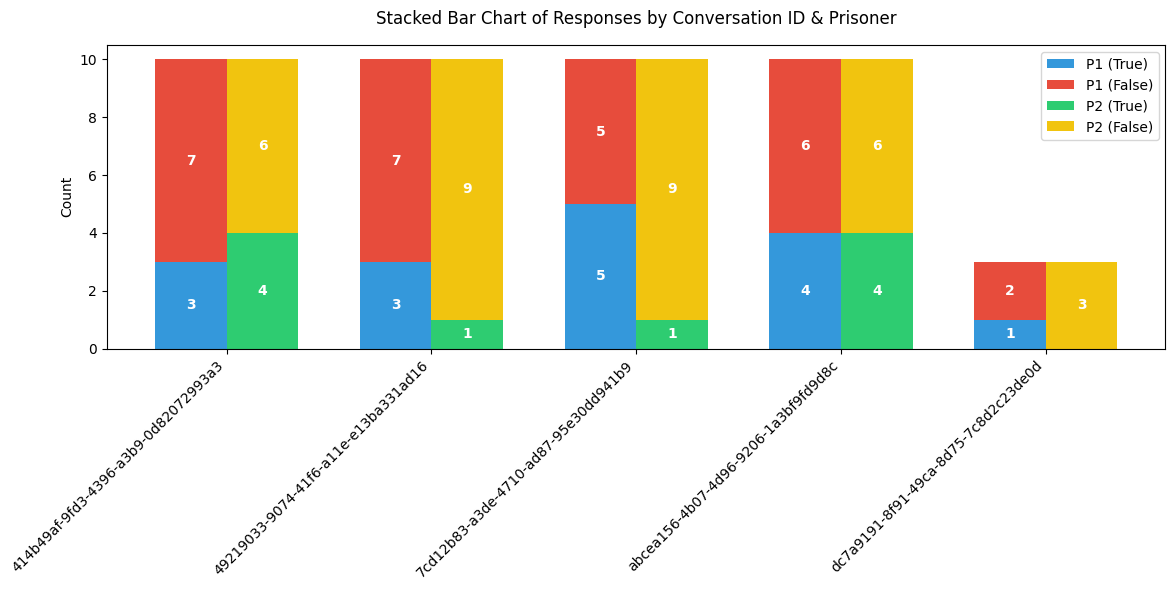

Summary of Responses:
 Response         False  True 
Prisoner Number              
1                   27     16
2                   33     10


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv('../../prisoner_logs_1601_0717.csv')

# Clean the Response column
df['Response'] = df['Response'].replace(['i will stay silent', 'silent', 'Stay silent', 'I will stay silent.'], 'False')
df['Response'] = df['Response'].map({'True': True, 'False': False})

# Group by Conversation ID, Prisoner Number, and Response, then count
grouped_data = df.groupby(['Conversation ID', 'Prisoner Number', 'Response']).size().unstack(fill_value=0)

# Prepare figure
fig, ax = plt.subplots(figsize=(12, 6))

# X positions for each conversation
conv_ids = sorted(grouped_data.index.levels[0])  # Ensure sorted for consistent labeling
x = np.arange(len(conv_ids))
width = 0.35

# Helper function to safely retrieve counts, defaulting to 0 if not present
def get_count(conv_id, prisoner_num, resp):
    # If the index combination doesn't exist, return 0
    try:
        return grouped_data.loc[(conv_id, prisoner_num), resp]
    except KeyError:
        return 0

# Build the arrays for stacking
p1_true_counts  = [get_count(cid, 1, True)  for cid in conv_ids]
p1_false_counts = [get_count(cid, 1, False) for cid in conv_ids]
p2_true_counts  = [get_count(cid, 2, True)  for cid in conv_ids]
p2_false_counts = [get_count(cid, 2, False) for cid in conv_ids]

# Colors
# Prisoner 1: True=#3498db (blue), False=#e74c3c (red)
# Prisoner 2: True=#2ecc71 (green), False=#f1c40f (yellow)
p1_true_bars = ax.bar(x - width/2, p1_true_counts, width,
                      label='P1 (True)', color='#3498db')
p1_false_bars = ax.bar(x - width/2, p1_false_counts, width,
                       bottom=p1_true_counts, label='P1 (False)', color='#e74c3c')

p2_true_bars = ax.bar(x + width/2, p2_true_counts, width,
                      label='P2 (True)', color='#2ecc71')
p2_false_bars = ax.bar(x + width/2, p2_false_counts, width,
                       bottom=p2_true_counts, label='P2 (False)', color='#f1c40f')

# Function to place labels inside each bar segment
def label_bars(bar_container, bottom_array):
    # bar_container: the BarContainer returned by plt.bar
    # bottom_array: array of the values stacked below these bars
    for bar, bottom_val in zip(bar_container, bottom_array):
        height = bar.get_height()
        if height > 0:
            # Center the label within the segment
            x_pos = bar.get_x() + bar.get_width() / 2
            y_pos = bottom_val + (height / 2)
            ax.text(
                x_pos,
                y_pos,
                str(int(height)),
                ha='center',
                va='center',
                color='white',
                fontweight='bold'
            )

# Label the bars
label_bars(p1_true_bars, [0]*len(p1_true_bars))         # True portion (bottom=0)
label_bars(p1_false_bars, p1_true_counts)               # False portion (bottom=True counts)
label_bars(p2_true_bars, [0]*len(p2_true_bars))         # True portion
label_bars(p2_false_bars, p2_true_counts)               # False portion

# Customize the plot
ax.set_title('Stacked Bar Chart of Responses by Conversation ID & Prisoner', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(conv_ids, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary
summary = df.groupby(['Prisoner Number', 'Response']).size().unstack(fill_value=0)
print("Summary of Responses:\n", summary)

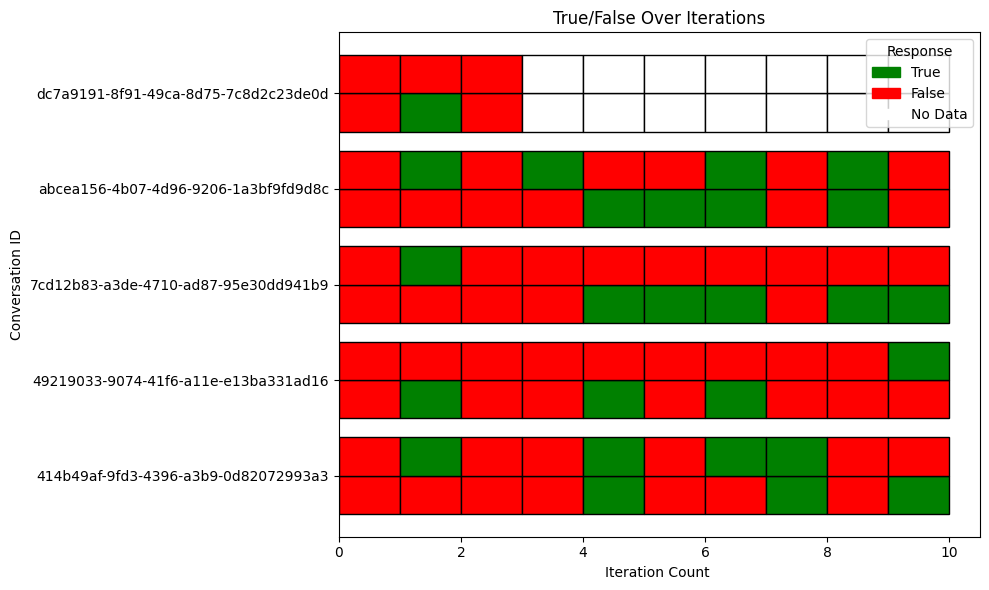

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# 1. Read and clean the CSV
df = pd.read_csv("../../prisoner_logs_1601_0717.csv")

# Replace silent variants with "False"
df['Response'] = df['Response'].replace(
    ['i will stay silent', 'silent', 'Stay silent', 'I will stay silent.'],
    'False'
)
df['Response'] = df['Response'].map({'True': True, 'False': False})

# 2. Assign Iterations (1..10) per (Conversation ID, Prisoner Number)
df['Iteration'] = df.groupby(['Conversation ID', 'Prisoner Number']).cumcount() + 1
df = df[df['Iteration'] <= 10]  # Keep only up to the 10th iteration

# 3. Build nested data structure for each conversation ID and prisoner
grouped = df.groupby(['Conversation ID', 'Prisoner Number', 'Iteration'])['Response'].first()
hierarchy = {}

for (conv_id, prisoner, iteration), response in grouped.items():
    if conv_id not in hierarchy:
        hierarchy[conv_id] = {}
    if prisoner not in hierarchy[conv_id]:
        # Initialize 10 slots as None so we can show missing data in white
        hierarchy[conv_id][prisoner] = [None] * 10
    hierarchy[conv_id][prisoner][iteration - 1] = response

# 4. Set up the figure
conversation_ids = sorted(hierarchy.keys())
y_positions = np.arange(len(conversation_ids))
bar_height = 0.4

plt.figure(figsize=(10, 6))
ax = plt.gca()

# 5. Plot two horizontal stacked bars (Prisoner 1 & Prisoner 2) per conversation
for i, conv_id in enumerate(conversation_ids):
    # Retrieve T/F/None data
    p1_data = hierarchy[conv_id].get(1, [None] * 10)
    p2_data = hierarchy[conv_id].get(2, [None] * 10)

    # Prisoner 1
    left_1 = 0
    for val in p1_data:
        width = 1
        if val is None:
            color = 'white'  # No data
        elif val is True:
            color = 'green'
        else:
            color = 'red'
        ax.barh(
            y_positions[i] - bar_height / 2,
            width,
            left=left_1,
            height=bar_height,
            color=color,
            edgecolor='black'
        )
        left_1 += width

    # Prisoner 2
    left_2 = 0
    for val in p2_data:
        width = 1
        if val is None:
            color = 'white'
        elif val is True:
            color = 'green'
        else:
            color = 'red'
        ax.barh(
            y_positions[i] + bar_height / 2,
            width,
            left=left_2,
            height=bar_height,
            color=color,
            edgecolor='black'
        )
        left_2 += width

# 6. Labeling and legend
ax.set_yticks(y_positions)
ax.set_yticklabels(conversation_ids)
ax.set_xlabel("Iteration Count ")
ax.set_ylabel("Conversation ID")
ax.set_title("True/False Over Iterations")

legend_handles = [
    mpatches.Patch(color='green', label='True'),
    mpatches.Patch(color='red', label='False'),
    mpatches.Patch(color='white', label='No Data')
]
plt.legend(handles=legend_handles, title="Response")

plt.tight_layout()
plt.show()

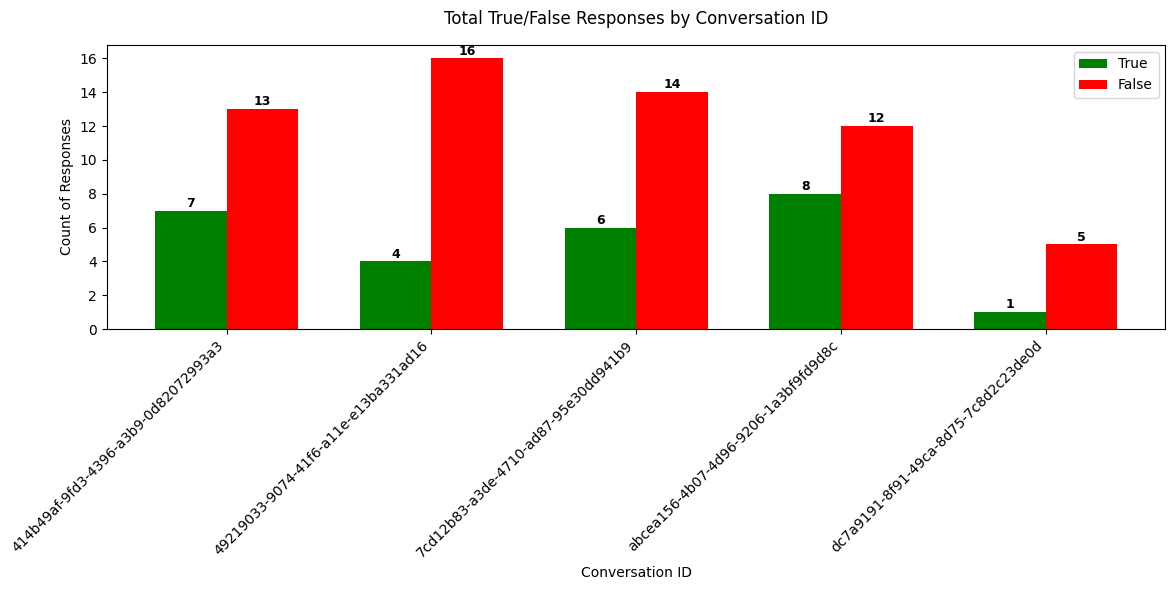

Summary of total True/False by Conversation ID:

 Response                              False  True 
Conversation ID                                   
414b49af-9fd3-4396-a3b9-0d82072993a3     13      7
49219033-9074-41f6-a11e-e13ba331ad16     16      4
7cd12b83-a3de-4710-ad87-95e30dd941b9     14      6
abcea156-4b07-4d96-9206-1a3bf9fd9d8c     12      8
dc7a9191-8f91-49ca-8d75-7c8d2c23de0d      5      1


In [9]:
# Read the CSV file
df = pd.read_csv('../../prisoner_logs_1601_0717.csv')

# Clean the Response column
df['Response'] = df['Response'].replace(['i will stay silent', 'silent', 'Stay silent', 'I will stay silent.'], 'False')
df['Response'] = df['Response'].map({'True': True, 'False': False})

# Group by Conversation ID and Response, then count how many times each response occurs
grouped_data = df.groupby(['Conversation ID', 'Response']).size().unstack(fill_value=0)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Extract conversation IDs (sorted for consistent labeling)
conv_ids = sorted(grouped_data.index)
x = np.arange(len(conv_ids))  # x-coordinates

# Extract the counts of True and False for each conversation
true_counts = [grouped_data.loc[cid, True] if True in grouped_data.columns else 0 for cid in conv_ids]
false_counts = [grouped_data.loc[cid, False] if False in grouped_data.columns else 0 for cid in conv_ids]

width = 0.35  # width of each bar

# Plot True bars (green) and False bars (red) side by side
bars_true = ax.bar(x - width/2, true_counts, width, label='True', color='green')
bars_false = ax.bar(x + width/2, false_counts, width, label='False', color='red')

# Add labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                height + 0.05,
                str(int(height)),
                ha='center', va='bottom',
                fontsize=9, fontweight='bold'
            )

add_labels(bars_true)
add_labels(bars_false)

# Customize the plot
ax.set_title('Total True/False Responses by Conversation ID', pad=15)
ax.set_xlabel('Conversation ID')
ax.set_ylabel('Count of Responses')
ax.set_xticks(x)
ax.set_xticklabels(conv_ids, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print a summary for verification:
summary = df.groupby(['Conversation ID', 'Response']).size().unstack(fill_value=0)
print("Summary of total True/False by Conversation ID:\n\n", summary)